<a href="https://colab.research.google.com/github/maiemahmoud/Noise-reduction/blob/main/Noise_Reduction_Using_N2V_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install n2v

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import n2v
print(tf.__version__)
print(n2v.__version__)

2.11.0
0.3.2


In [ ]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#METHOD 1: Loading images using load_imgs_from_directory method
# We load all the '.png' files from the directory.
# The function will return a list of images (numpy arrays).
imgs = datagen.load_imgs_from_directory(directory = "/content/drive/MyDrive/noise_ofdm/noisy_images/", 
                                        filter='*.png',dims='YXC')  #ZYX for 3D

#gdrive/My Drive/noise_ofdm/noisy_images/
# Let's look at the shape of the image
print(len(imgs))
print('shape of loaded images: ',imgs[0].shape)
# If the image has four color channels (stored in the last dimension): RGB and Aplha.
# We are not interested in Alpha and will get rid of it.
imgs[0] = imgs[0][...,:3]
print('shape without alpha:    ',imgs[0].shape)
print('The data type of the first image is: ', imgs[0].dtype)


49
shape of loaded images:  (1, 256, 256, 3)
shape without alpha:     (1, 256, 256, 3)
The data type of the first image is:  float32


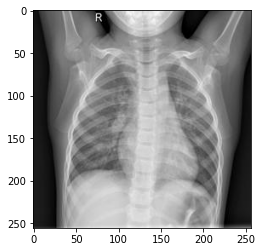

In [ ]:
# Let's look at the image.
plt.figure()
plt.imshow(imgs[0][0,:,:,:])
plt.show()

In [ ]:
patch_size = 64

In [ ]:
# Patches are extracted from all images and combined into a single numpy array
patch_shape = (patch_size,patch_size)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)


Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64, 64, 3)
Generated patches: (128, 64,

In [ ]:
patches.shape

(6272, 64, 64, 3)

In [ ]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
train_val_split = int(patches.shape[0] * 0.8)
X = patches[:train_val_split]
X_val = patches[train_val_split:]

In [ ]:
print(X.shape)
print(X.dtype)
print(X_val.shape)

(5017, 64, 64, 3)
float32
(1255, 64, 64, 3)


In [ ]:
# Just in case you don't know how to access the docstring of a method:
datagen.generate_patches_from_list?

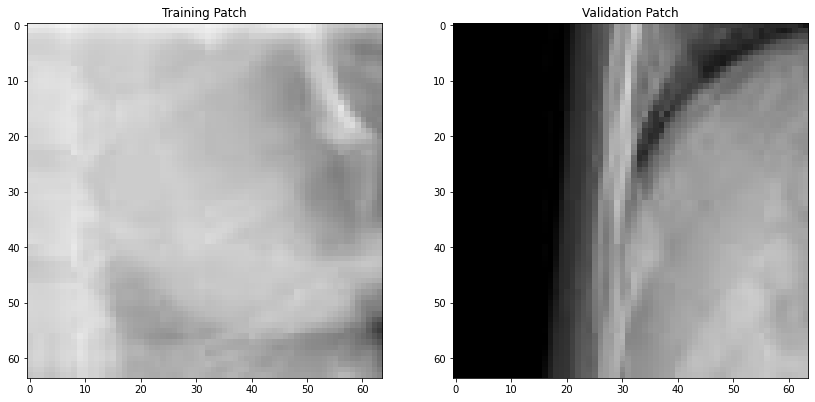

In [ ]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...])
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...])
plt.title('Validation Patch');

In [ ]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch 
# is shown once per epoch. 
train_batch = 32
config = N2VConfig(X, unet_kern_size=3, 
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=20, train_loss='mse', 
                   batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['0.48446956', '0.48446956', '0.48446956'],
 'stds': ['0.24782327', '0.24782327', '0.24782327'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 3,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 3),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 156,
 'train_learning_rate': 0.0004,
 'train_batch_size': 32,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [ ]:
# a name used to identify the model --> change this to something sensible!
model_name = 'n2v_2D_stars'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

<h2>Training</h2><p>


In [ ]:
# We are ready to start training now.
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1255/1255 [00:00<00:00, 1343.96it/s]


Epoch 1/20
  6/156 [>.............................] - ETA: 10s - loss: 0.5918 - n2v_mse: 0.5918 - n2v_abs: 0.5324

156/156 [==============================] - 36s 98ms/step - loss: 0.0684 - n2v_mse: 0.0684 - n2v_abs: 0.1649 - val_loss: 0.2267 - val_n2v_mse: 0.2255 - val_n2v_abs: 0.3764 - lr: 4.0000e-04
Epoch 2/20
156/156 [==============================] - 14s 88ms/step - loss: 0.0231 - n2v_mse: 0.0231 - n2v_abs: 0.1152 - val_loss: 0.0726 - val_n2v_mse: 0.0723 - val_n2v_abs: 0.2069 - lr: 4.0000e-04
Epoch 3/20
156/156 [==============================] - 13s 85ms/step - loss: 0.0204 - n2v_mse: 0.0204 - n2v_abs: 0.1118 - val_loss: 0.0195 - val_n2v_mse: 0.0195 - val_n2v_abs: 0.0964 - lr: 4.0000e-04
Epoch 4/20
156/156 [==============================] - 13s 85ms/step - loss: 0.0153 - n2v_mse: 0.0153 - n2v_abs: 0.0968 - val_loss: 0.0214 - val_n2v_mse: 0.0213 - val_n2v_abs: 0.1016 - lr: 4.0000e-04
Epoch 5/20
156/156 [==============================] - 14s 87ms/step - loss: 0.0172 - n2v_mse: 0.0172 - n2v_abs: 0.1041 - val_loss: 0.0200 - val_n2v_mse: 0.0199 - val_n2v_abs: 0.0946 - lr: 4.0000e-04
Epoch 6/20
156/1

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


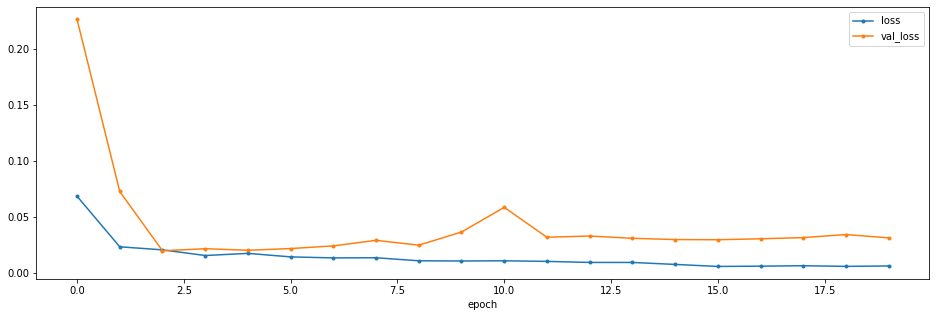

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

<h1>Denoising images using the trained model</h1>

In [ ]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread, imsave
from csbdeep.io import save_tiff_imagej_compatible

In [ ]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.  
model_name = 'n2v_2D_stars'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


Denoising (prediction)

In [ ]:
# We load the data we want to process.
img = imread('/content/drive/MyDrive/noise_ofdm/noisy_images/img10.png')
img.dtype

dtype('float32')

In [ ]:

# Here we denoise the image (predict)
# The parameter 'n_tiles' can be used if images are to big for the GPU memory.
# If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
# This can take longer.
pred = model.predict(img, axes='YXC')



1/1 [==============================] - 2s 2s/step


In [ ]:
pred.shape

(256, 256, 3)

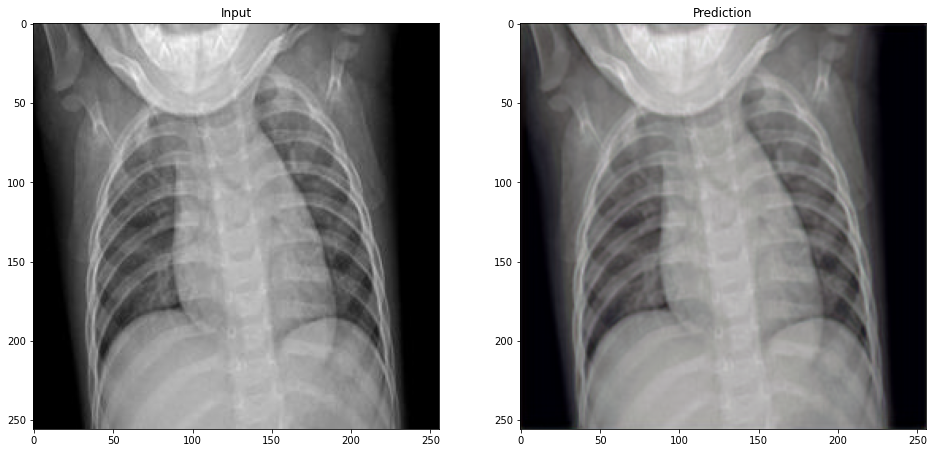

In [ ]:
# Let's look at the results.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred)
plt.title('Prediction');

In [ ]:
save_tiff_imagej_compatible('pred_train.tif', pred, axes='YXC')